# Network Analysis Using Reinforcement Learning
## Spring 2022: Shaoyu Pei, Avery Peiffer

## Advisor: Dr. Mai Abdelhakim

## Notebook 1: Introduction and Network Setup
The purpose of this notebook is to show you how we define an IoT network using the `networkx` package. For this study, we are interested in the idea that devices can manipulate data transmitted in packets as it is being forwarded from a source device to a destination device. This would result in incorrect data arriving at the destination device. This may happen intentionally, as a result of a cyber attack on the device, or unintentionally. We refer to these types of devices as malicious, because they can compromise the integrity of the packets that are sent throughout the network. Overall, we want to use reinforcement learning to create an algorithm that can identify which devices are likely to be malicious, so that we can avoid them when transmitting data through the network. 

Please refer to Dr. Abdelhakim's paper in `../papers/` for more details, as that is the paper that forms the basis of this work.

**Note:** If you get any errors due to packages not being installed, please add them to the cell below. We might have not encountered these errors due to already having those packages installed on our computers for other courses/projects/etc. You can install a package with: `!pip3 install <package-name>`

In [2]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

We represent a network as a graph, made up of nodes and edges. A node represents a device and an edge represents a connection between two devices. We use a partial mesh topology to define the network, which means that not all pairs of nodes are directly connected to each other (which would be a full mesh topology). The following image shows an example of a network created using the `networkx` package.

![Network Example](img/network_example.png)

**Note**: To keep things clear as we write code, we have a small convention in defining the graph. The source node is always Node 0, and the destination node is always the highest-numbered node (9, in this image).

`Networkx` allows us to create a random graph according to a set of parameters. We define those parameters here:
* `network_size` - the number of devices in the network.
* `edge_prob` - how likely it is that any two devices in the network are connected. `Edge_prob = 1` means that every device is connected to every other device; this isn't useful for this study, as we want to learn about the paths from one device to another. However, we want the graph to be connected; that is, there does exist at least one path from one device to another. For this reason, we generally start with a low `edge_prob`, then make use of a method to add edges to the network until it is connected. This will result in a sparse, but connected, graph.

We also use some parameters to determine which devices in the network are malicious, as well as their potency.
* `percent_mal` - the percentage of malicious devices in the network. 
* `attack_probs` - how likely it is that the malicious devices will attack on a single transmission. We represent this as a list of two values, which form the uniform distribution from which the attack probability is drawn.

In [3]:
network_size = 20      
edge_prob = 0.1 
percent_mal = 0.3
attack_probs = [0.2, 0.8] 

Here, we create the graph according to the hyperparameters defined above. We start with a random graph; then, we add edges using the `random_edge` function until the graph is connected. Again, the source node is always node 0 and the destination node is always the highest-numbered node.

In [4]:
def render(graph):
    nx.draw(graph, with_labels=True)
    plt.show()
    
def random_edge(graph):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    chosen_edge = random.choice(edges)
    chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
    
    graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
    
    return graph

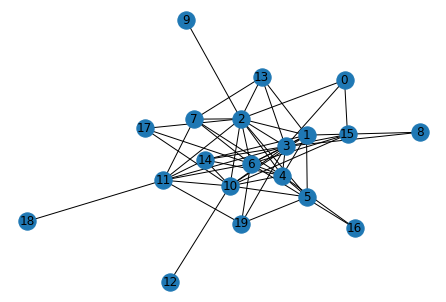

In [6]:
src = 0
dst = network_size - 1

G = nx.gnp_random_graph(network_size, edge_prob)

while not nx.is_connected(G):
    G = random_edge(G)

render(G)

At this point, we create a class to encode information for each node about whether it is malicious and, if so, what its attack probability is. We call this class `device`. We use a somewhat lazy class definition to accomplish this, as we can add attributes to the class later. 

We then randomly assign some number (according to `percent_mal`) of the devices to be malicious. We will assume that the source and destination nodes can't be malicious, since that defeats the purpose of the study.

In [7]:
class device:
    pass

In [8]:
mal_nodes = []

num_mal = int(network_size * percent_mal)

while (num_mal > 0):
    rand = np.random.randint(0, network_size)
    
    if rand != src and rand != dst and rand not in mal_nodes:
        mal_nodes.append(rand)
        num_mal -= 1

For each node in the graph, we create a corresponding `device` class for it. Each device has the following attributes:
* `node` - the label of the node in the graph.
* `mal` - a Boolean flag indicating whether the device is malicious.
* `attack_prob` - a random number drawn from the uniform distribution bounded by `attack_probs` above. This indicates how likely the device is to attack on any given transmission. If the device is not malicious, `attack_prob = 0`.

In [10]:
nodes = list(range(0, network_size))
devices = []

for node in nodes:
    d = device()
    d.node = node
    
    if node in mal_nodes:
        d.mal = True
        d.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
    else:
        d.mal = False
        d.attack_prob = 0
        
    devices.append(d)

To verify that our network is set up correctly, we can run a brief test. First, we will print out the malicious nodes in the graph. 

In [15]:
print('Malicious Nodes:')
for d in devices:
    if d.mal:
        print(f'{d.node} - attack probability is {d.attack_prob:.2f}.')

Malicious Nodes:
3 - attack probability is 0.34.
4 - attack probability is 0.45.
9 - attack probability is 0.47.
10 - attack probability is 0.63.
15 - attack probability is 0.39.
16 - attack probability is 0.69.


The graph's `all_simple_paths` attribute gives us all of the paths from the source node to the destination node (that only visit a node once). We will go through each path and determine if a device has corrupted the path. For each malicious node along the path, we generate a random number and compare it to the node's attack probability to see if it will attack the path. 

The `is_corrupted` function represents how our network is actually able to tell whether or not a transmission was corrupted. In real life, this would be accomplished by the end device doing a hash operation on the incoming data and checking the result. In the future, this function could be changed to more closely resemble the real-life version, but still provides useful information in its current state.

**Note**: This test might take some time to run if the number of nodes is high.

In [18]:
def is_corrupted(path, verbose=True):
    for node in path: 
        attack_prob = devices[node].attack_prob
        attacked = random.uniform(0,1) < attack_prob
        
        if attacked:
#             if verbose:
#                 print('Path = ', path)
#                 print('Node %d attacked this path' % node)
            return True
    return False

In [19]:
paths = list(nx.all_simple_paths(G, src, dst))
paths_corruption = []

for path in paths:
    paths_corruption.append(is_corrupted(path))

Path =  [0, 15, 6, 1, 3, 14, 11, 2, 13, 7, 4, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 13, 7, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 7, 4, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 7, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 17, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 17, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 4, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 2, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 7, 13, 2, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 7, 13, 2, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 14, 11, 7, 13, 2, 17, 10, 4, 5, 19]
N

Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 5, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 5, 2, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 5, 2, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 7, 11, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 7, 13, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 7, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 7, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 2, 13, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 3, 10, 14, 4, 2, 7, 11, 19]

Path =  [0, 15, 6, 1, 5, 4, 7, 13, 3, 10, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 13, 3, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 13, 3, 10, 17, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 13, 3, 2, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 13, 3, 2, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 13, 3, 2, 17, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 13, 3, 2, 17, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 2, 11, 10, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 2, 11, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 2, 11, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 2, 11, 14, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 2, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 5, 4, 7, 2, 13, 3,

Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 11, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 13, 7, 11, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 13, 7, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 13, 3, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 13, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 7, 11, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 7, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 7, 13, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 4, 10, 2, 7, 13, 3, 19]
Node 10 attacked this path
Path =  

Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 3, 2, 5, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 3, 2, 5, 10, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 4, 3, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 4, 3, 2, 17, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 3, 2, 17, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 4, 3, 2, 17, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 14, 3, 13, 7, 11, 2, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 14, 3, 13, 7, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 4, 14, 3, 13, 7, 11, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 4, 14, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 4, 14, 3, 13, 7, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 4, 14, 3, 13, 7, 11, 10, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 4, 14, 3, 13, 7, 11, 10, 1

Node 3 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 11, 7, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 11, 7, 13, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 11, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 11, 7, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 11, 10, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 11, 10, 17, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 10, 5, 2, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 10, 5, 2, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 10, 5, 2, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 8, 3, 4, 14, 10, 11, 2, 5, 19]
Node 4 attacked this path
Pa

Path =  [0, 15, 6, 1, 14, 3, 4, 2, 17, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 2, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 2, 17, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 2, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 2, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 10, 4, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 14, 3, 13, 7, 11, 10, 2, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 14, 3,

Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 4, 7, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 4, 7, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 4, 7, 13, 3, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 4, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 4, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 3, 13, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 5, 2, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 11, 2, 13, 7, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 11, 2, 13, 7, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 11, 2, 13, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 14, 10, 11

Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 5, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 5, 4, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 14, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 14, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 3, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 3, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 5, 10, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 5, 10, 4, 14, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 5, 10, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 11, 2, 5,

Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 5, 4, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 5, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 5, 4, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 5, 4, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 5, 4, 14, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 5, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 5, 4, 14, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 11, 14, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 11, 14, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 7, 2, 17, 10, 11, 3, 

Path =  [0, 15, 6, 1, 13, 2, 3, 4, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 4, 7, 11, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 4, 7, 11, 14, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 4, 14, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 4, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 4, 14, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 11, 7, 4, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 11, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 11, 7, 4, 14, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 11, 10, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 11, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 11, 10, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 13, 2, 3, 11, 14, 10, 4, 5, 19]
Node 15

Path =  [0, 15, 6, 1, 2, 7, 13, 3, 4, 14, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 4, 14, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 10, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 14, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 14, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 11, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 10, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 2, 7, 13, 3, 10, 5, 4, 1

Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 4, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 4, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 13, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 5, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 5, 4, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 4, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 3, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 7, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 11, 14, 3, 4, 5, 19]
Node 10 attacked this

Path =  [0, 15, 6, 1, 10, 17, 2, 7, 11, 14, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 13, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 13, 3, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 13, 3, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 13, 3, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 13, 3, 11, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 4, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 4, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 1, 10, 17, 2, 7, 4, 14, 3, 11

Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 1, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 8, 1, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 4, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 13, 1, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 4, 5, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 4, 5, 1, 8, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 4, 5, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 2, 10, 14, 4, 5

Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 1, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 14, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 14, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 4, 14, 1, 13, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 5, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 2, 13, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 2, 13, 3, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 2, 13, 3, 1, 14, 4, 5, 19]
Node 1

Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 5, 2, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 5, 2, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 3, 13, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 3, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 2, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 14, 4, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 13, 2, 5, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 13, 2, 5, 4, 14, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 13, 2, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 10, 1, 13, 2, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7

Path =  [0, 15, 6, 7, 11, 14, 4, 10, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 13, 3, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 13, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 13, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 13, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 13, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 5, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 5, 1, 8, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 5, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 4, 10, 17, 2, 1, 3, 19]
Node 15 attacked th

Path =  [0, 15, 6, 7, 11, 14, 1, 2, 5, 10, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 5, 4, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 17, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 17, 10, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 17, 10, 5, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 17, 10, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 17, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 4, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 4, 10, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 4, 5, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 11, 14, 1, 2, 4, 3, 19]
Node 4 

Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 14, 1, 8, 3, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 14, 1, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 14, 1, 10, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 14, 1, 10, 5, 4, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 14, 1, 10, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 14, 1, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 3, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 3, 1, 4, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 3, 1, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 3, 1, 14, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 3, 1, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 11, 3, 1, 14, 4, 10, 5, 19]
Node 4 attacked this path
Path = 

Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 10, 14, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 10, 14, 4, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 10, 14, 4, 3, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 10, 3, 14, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 10, 3, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 4, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 4, 10, 11, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 4, 10, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 4, 10, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 4, 10, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 1, 5, 4, 10, 14, 11, 19]
Node 15 attacked this path
Path =  

Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 11, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 11, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 3, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 3, 8, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 10, 1, 8, 3, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 1, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14, 1, 3, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 2, 4, 14,

Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 5, 10, 17, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 5, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 5, 2, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 5, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 14, 1, 4, 2, 17, 10, 11, 19]
Node 3 attacked this path


Path =  [0, 15, 6, 7, 13, 3, 10, 4, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 1, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 1, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 14, 11, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 14, 11, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 14, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 14, 1, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 14, 1, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 2, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 2, 11, 14, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 2, 5, 1, 14, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 3, 10, 4, 2, 5, 19]
Node 1

Path =  [0, 15, 6, 7, 13, 1, 3, 4, 5, 2, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 5, 2, 17, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 5, 2, 17, 10, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 11, 2, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 11, 2, 17, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 11, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 11, 10, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 10, 5, 2, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 3, 4, 14, 10, 11, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 

Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 5, 10, 17, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 5, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 5, 2, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 5, 2, 17, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 2, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 2, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 2, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 14, 4, 2, 17, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 8, 3, 4, 10, 5, 19]
Node 

Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 10, 3, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 14, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 14, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 14, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 10, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 3, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 13, 1, 2, 5, 4, 3, 14, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 

Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 3, 13, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 3, 13, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 3, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 3, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 5, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 5, 2, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 5, 2, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 5, 2, 13, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 5, 2, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 10, 1, 5, 2, 3, 14, 11, 19]
Node 15 attacked this path
P

Path =  [0, 15, 6, 7, 4, 3, 8, 1, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 2, 17, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 2, 17, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 5, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 11, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 14, 11, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 3, 8, 1, 10, 17, 2, 11, 19]
Node 15 attacked this pa

Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 11, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 14, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 3, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 5, 10, 3, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 17, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 17, 10, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 1, 2, 17, 10, 11, 3, 19]
Node 

Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 10, 3, 13, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 10, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 10, 3, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 11, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 13, 3, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 10, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 10, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 4, 14, 1, 5, 2, 17

Path =  [0, 15, 6, 7, 2, 11, 14, 3, 10, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 3, 10, 4, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 3, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 3, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 3, 10, 1, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 5, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 5, 1, 8, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 5, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 3, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 11, 14, 10, 4, 1, 3, 19]
Node 10 a

Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 3, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 3, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 11, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 11, 3, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 10, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 10, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 4, 14, 10, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 8, 3, 14, 11, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 13, 1, 8, 3, 14, 

Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 1, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 1, 13, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 1, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 14, 3, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 14, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 14, 3, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 14, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 17, 10, 4, 14, 11, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15

Path =  [0, 15, 6, 7, 2, 4, 5, 10, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 11, 14, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 1, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 1, 8, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 7, 2, 4, 5, 10, 14, 1, 13, 3, 11, 19]
Node 4 attacke

Path =  [0, 15, 6, 4, 10, 11, 7, 2, 13, 1, 8, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 13, 1, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 5, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 5, 1, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 5, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 1, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 10, 11, 7, 2, 3, 14, 1, 5, 19]
Node 4 attacked this pa

Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 11, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 11, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 11, 14, 1, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 2, 11, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 2, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 7, 2, 1, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 2, 11, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 2, 7, 11, 14, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 10, 3, 13, 2, 5,

Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 3, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 3, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 13, 7, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 13, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 13, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 2, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 5, 10, 1, 8, 3, 2, 7, 11, 19]
No

Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 10, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 10, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 10, 1, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 10, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 14, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 14, 10, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 14, 10, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 14, 10, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 14, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 14, 1, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 11, 14, 1, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 5, 2, 13, 7, 11, 10, 14, 3, 19]
Node 4 at

Node 3 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 13, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 13, 3, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 5, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 17, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 10, 5, 2, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 10, 5, 2, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 11, 14, 1, 1

Path =  [0, 15, 6, 4, 7, 13, 3, 14, 1, 10, 17, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 14, 1, 10, 17, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 10, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 17, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 17, 10, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 17, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 1, 14, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 2, 1, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 13, 3, 11, 10, 5, 19]
Node 15 attac

Path =  [0, 15, 6, 4, 7, 2, 5, 1, 8, 3, 14, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 8, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 8, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 8, 3, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 3, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 11, 10, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 10, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 14, 10, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 7, 2, 5, 1, 13, 3, 14, 11, 19]
Node 3 attacked

Node 4 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 2, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 2, 7, 13, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 2, 7, 13, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 2, 17, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 2, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 2, 1, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 7, 13, 2, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 7, 13, 2, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 7, 13, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 7, 13, 2, 17, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 3, 14, 11, 7, 13, 2, 17, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 

Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 2, 7, 13, 3, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 2, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 2, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 2, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 13, 7, 2, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 13, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 13, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 5, 10, 14, 3, 2, 7, 11, 1

Node 10 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 11, 7, 2, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 11, 7, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 11, 7, 2, 17, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 11, 10, 17, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 10, 5, 2, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 10, 11, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 10, 11, 7, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 1, 13, 3, 14, 10, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 

Path =  [0, 15, 6, 4, 14, 3, 10, 1, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 11, 7, 13, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 11, 7, 13, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 11, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 11, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 13, 7, 11, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 13, 7, 11, 10, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 13, 1, 5, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 13, 1, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 14, 3, 2, 13, 1, 10, 11, 19]
Node 15 attacked this path
Path 

Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 5, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 5, 2, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 5, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 13, 7, 11, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 13, 7, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 13, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 13, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 13, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 13, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 14, 10, 3, 8, 1, 2, 11, 19]
Node 10 attacked this pat

Path =  [0, 15, 6, 4, 2, 11, 10, 3, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 3, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 1, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 10, 1, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 14, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 14, 3, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 14, 3, 8, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 14, 3, 13, 1, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 4, 2, 11, 14, 3, 19

Node 10 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 11, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 11, 14, 1, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 10, 5, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 10, 11, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 10, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 3, 10, 1, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 1, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 1, 3, 14, 11, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 1, 3, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 4, 2, 7, 13, 1, 3, 14, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 

Path =  [0, 15, 6, 3, 1, 4, 2, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 13, 7, 11, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 13, 7, 11, 14, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 7, 11, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 7, 11, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 5, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 17, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 1, 4, 2, 17, 10, 11,

Node 3 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 14, 4, 7, 13, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 14, 4, 7, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 14, 4, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 14, 4, 2, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 11, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 11, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 13, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 13, 7, 11, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 13, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 13, 7, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 1, 10, 17, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 1, 10,

Path =  [0, 15, 6, 3, 14, 11, 7, 13, 2, 1, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 2, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 2, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 2, 4, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 2, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 2, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 2, 4, 1, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 1, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 1, 4, 10, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 1, 4, 10, 17, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 7, 13, 1, 4, 2, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 11, 

Path =  [0, 15, 6, 3, 14, 4, 2, 7, 13, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 7, 13, 1, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 7, 13, 1, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 5, 10, 1, 13, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 5, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 5, 1, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 17, 10, 5, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 17, 10, 11, 7, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 17, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 17, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 14, 4, 2, 17, 10, 1, 13, 7, 11, 19]


Path =  [0, 15, 6, 3, 4, 7, 2, 11, 14, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 5, 10, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 14, 11, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 14, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 13, 1, 10, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 10, 5, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 4, 7, 2, 10, 11, 14, 1, 5, 19]
Node 10 attacke

Node 3 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 1, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 1, 10, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 1, 10, 14, 11, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 1, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 1, 10, 17, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 1, 10, 17, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 14, 11, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 14, 11, 2, 10, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 14, 11, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 14, 11, 2, 17, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 14, 11, 2, 17, 10, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 7, 4, 14, 11, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0,

Path =  [0, 15, 6, 3, 13, 1, 14, 10, 2, 5, 4, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 2, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 2, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 17, 2, 11, 7, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 17, 2, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 17, 2, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 17, 2, 5, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 17, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 10, 17, 2, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 4, 10, 5, 2, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 4, 10, 11, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 13, 1, 14, 4, 10, 11, 7, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 

Node 10 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 4, 2, 7, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 4, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 4, 2, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 13, 7, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 13, 7, 4, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 13, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 7, 13, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 7, 13, 1, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 7, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 7, 4, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 11, 14, 10, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 11, 14,

Path =  [0, 15, 6, 3, 10, 17, 2, 1, 4, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 14, 11, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 14, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 14, 4, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 13, 7, 11, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 1, 13, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 4, 5, 1, 14, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 4, 5, 1, 13, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 10, 17, 2, 4, 7, 11, 19]
Node 1

Path =  [0, 15, 6, 3, 2, 17, 10, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 4, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 4, 7, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 4, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 1, 5, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 1, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 1, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 14, 1, 13, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 1, 5, 4, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 3, 2, 17, 10, 1, 5, 4, 

Path =  [0, 15, 6, 11, 2, 7, 13, 3, 1, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 1, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 1, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 1, 10, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 4, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 14, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 14, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 14, 4, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 2, 7, 13, 3, 8, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11

Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 8, 1, 13, 7, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 8, 1, 13, 7, 4, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 8, 1, 10, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 8, 1, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 8, 1, 10, 14, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 10, 4, 7, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 10, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 10, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 10, 1, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 10, 1, 13, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 2, 3, 14, 4, 10,

Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 8, 3, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 14, 3, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 14, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 10, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 1, 10, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 14, 3, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 14, 3, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 14, 3, 8, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 2, 4, 14, 3, 10, 1, 5, 19]
Node 3 attacked this path
Pa

Path =  [0, 15, 6, 11, 7, 13, 1, 14, 3, 2, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 4, 5, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 4, 3, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 4, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 5, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 5, 4, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 5, 2, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 5, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 14, 10, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 13, 1, 

Path =  [0, 15, 6, 11, 7, 4, 1, 3, 10, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 3, 10, 17, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 3, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 3, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 3, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 10, 2, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 10, 2, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 10, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 10, 17, 2, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 10, 17, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 4, 1, 5, 2, 13, 3, 19]
Node 3 attacked this path
Path =  [

Path =  [0, 15, 6, 11, 7, 2, 5, 4, 14, 10, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 5, 4, 14, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 5, 4, 14, 1, 8, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 5, 4, 14, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 5, 4, 14, 1, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10, 4, 5, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10, 4, 5, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10, 4, 5, 1, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10, 4, 5, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10, 4, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10, 4, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 7, 2, 17, 10

Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 13, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 13, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 13, 1, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 13, 1, 2, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 13, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 13, 1, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 1, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 5, 4, 7, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10

Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 3, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 5, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 4, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 8, 3, 14, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 8, 3, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 14, 3, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 10, 17, 2, 7, 13, 1, 14, 3, 19]
Node 10 attacked this path
P

Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 10, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 10, 17, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 7, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 7, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 7, 2, 17, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 4, 2, 17, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 2, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 2, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 2, 7, 4, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 3, 13, 1, 2, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 1

Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 4, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 13, 7, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 13, 7, 4, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 13, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 13, 7, 2, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 13, 2, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 2, 13, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 2, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 8, 3, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 10, 1, 13, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 

Path =  [0, 15, 6, 11, 14, 4, 2, 1, 13, 3, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 1, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 1, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 3, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 3, 8, 1, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 3, 13, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 3, 13, 1, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 3, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 14, 4, 2, 3, 10, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 11, 14, 1, 3, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 14, 1, 3, 4, 10, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 14, 1, 3, 4, 10, 17, 2, 5, 19]
Node 4 attacked this path
Path =  [0,

Path =  [0, 15, 6, 11, 3, 8, 1, 10, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 14, 4, 7, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 14, 4, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 14, 4, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 17, 2, 13, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 17, 2, 7, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 17, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 3, 8, 1, 10, 17, 2, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 3, 14, 10, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 11, 3, 14, 10, 4, 7, 13, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 11, 3, 14, 10, 4, 7, 13, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 11, 3, 14, 10, 4, 7, 

Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 10, 1, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 4, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 4, 10, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 4, 1, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 1, 4, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 14, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 11, 7, 13, 3, 4

Path =  [0, 15, 6, 2, 11, 14, 10, 4, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 4, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 4, 1, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 1, 4, 7, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 1, 4, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 1, 13, 7, 4, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 4, 7, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 4, 7, 13, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 11, 14, 10, 5, 4, 7, 13, 1, 8, 3, 19]


Node 4 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 14, 4, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 14, 4, 7, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 5, 4, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 5, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 11, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 14, 11, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 13, 3, 1, 10, 14, 4, 5, 19

Node 10 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 8, 3, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 14, 3, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 14, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 14, 11, 7, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 10, 4, 1, 13, 7, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 

Path =  [0, 15, 6, 2, 7, 11, 10, 4, 14, 3, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 4, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 4, 14, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 4, 14, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 4, 14, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 4, 14, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 5, 1, 4, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 5, 1, 8, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 5, 1, 14, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 5, 1, 14, 4, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 5, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 5, 4, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 7, 11, 10, 5, 4, 1, 14, 3, 19]
Node 15 

Node 4 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 5, 10, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 5, 10, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 5, 10, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 14, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 14, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 14, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 11, 14, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 3, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 7, 13, 1, 4, 

Path =  [0, 15, 6, 2, 5, 10, 3, 13, 7, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 3, 13, 1, 4, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 3, 13, 1, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 3, 13, 1, 14, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 1, 3, 14, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 1, 3, 4, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 1, 3, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 1, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 1, 3, 13, 7, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 5, 10, 1, 4, 7, 11, 14, 3, 19]
Node 4 attacked this path
Path =

Node 15 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 11, 14, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 4, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 4, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 4, 14, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 4, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 7, 4, 14, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 3, 14, 4, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 17, 10, 5, 1, 13, 

Path =  [0, 15, 6, 2, 1, 3, 4, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 5, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 5, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 7, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 7, 11, 14, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 14, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 14, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 4, 14, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 13, 7, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 1, 3, 13, 7, 11, 10, 4, 5, 19]
Node 15 

Path =  [0, 15, 6, 2, 4, 5, 10, 3, 14, 1, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 3, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 3, 13, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 3, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 8, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 8, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 14, 3, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 4, 5, 10, 1, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6

Path =  [0, 15, 6, 2, 3, 8, 1, 13, 7, 4, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 13, 7, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 13, 7, 4, 14, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 13, 7, 4, 14, 11, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 13, 7, 4, 14, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 13, 7, 4, 14, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 10, 4, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 10, 4, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 10, 5, 4, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 10, 5, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 10, 11, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 2, 3, 8, 1, 10, 11, 19]
Node 3 atta

Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 13, 7, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 13, 7, 2, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 13, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 13, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 13, 3, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 2, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 2, 7, 13, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 14, 1, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 3, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 11, 3, 1, 13, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16,

Path =  [0, 15, 6, 16, 4, 10, 3, 8, 1, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 2, 13, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 2, 7, 13, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 2, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 7, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 7, 13, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 7, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 7, 13, 1, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 7, 2, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 7, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 10, 3, 14, 11, 7, 2, 1, 5, 19]
Node 16 attacked this

Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 13, 7, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 13, 7, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 13, 7, 11, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 13, 3, 14, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 13, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 1, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 3, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 3, 1, 13, 7, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 10, 17, 2, 3, 8, 1, 14, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4,

Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 10, 14, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 10, 14, 1, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 10, 14, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 10, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 10, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 10, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 10, 1, 14, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 14, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11, 14, 10, 1, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 5, 2, 13, 7, 11,

Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 13, 1, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 10, 1, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 17, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 3, 2, 1, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 10, 5, 1, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 10, 5, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 10, 5, 1, 13, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 11, 14, 10, 5, 1, 13, 3, 1

Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 5, 10, 17, 2, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 5, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 5, 2, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 5, 2, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 5, 2, 17, 10, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 5, 2, 17, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 14, 11, 2, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 14, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 14, 11, 2, 17, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 13, 3, 1,

Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 5, 1, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 5, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 5, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 3, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 7, 2, 11, 14, 10, 1, 13, 3, 19]
Node 16 attacked this 

Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 10, 14, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 10, 17, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 10, 17, 2, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 10, 17, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 2, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 2, 10, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 2, 10, 14, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 2, 17, 10, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 8, 1, 5, 2, 17, 10, 14, 11, 19]
Node 15 attacked

Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 11, 14, 1, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 11, 14, 1, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 11, 7, 13, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 11, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 13, 7, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 13, 7, 11, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 13, 1, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 7, 11, 14, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 3, 10, 2, 7, 13, 1, 5, 19]
Node 16 attacked this path
Path =  

Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 13, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 13, 3, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 13, 3, 10, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 13, 3, 10, 17, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 13, 3, 2, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 13, 3, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 13, 3, 2, 17, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 2, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 2, 13, 3, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 2, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 2, 10, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 1, 14, 11, 7, 2, 5, 10, 3, 19]
Node 15 

Path =  [0, 15, 6, 16, 4, 14, 3, 1, 2, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 2, 17, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 2, 17, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 5, 2, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 5, 2, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 5, 2, 7, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 11, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 11, 7, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 11, 7, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3, 1, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 3

Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 1, 2, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 13, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 13, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 13, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 7, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 7, 13, 1, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 7, 13, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 1, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 11, 10, 5, 2, 3, 19]
Node 15 attacked this path
Pat

Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 10, 1, 2, 7, 13, 3, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 10, 1, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 10, 1, 2, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 10, 1, 2, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 11, 2, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 11, 2, 17, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 11, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 11, 10, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 11, 10, 17, 2, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 14, 1, 3, 13, 7, 2,

Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 14, 1, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 10, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 14, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 14, 10, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 11, 14, 1, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 10, 5, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 13, 3, 10, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6,

Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 14, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 14, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 14, 11, 7, 13, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 3, 14, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 3, 13, 7, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 10, 3, 11, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 8, 3, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 16, 4, 2, 1, 8, 3, 14, 11, 10, 

Path =  [0, 15, 6, 17, 10, 4, 3, 13, 2, 7, 11, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 2, 5, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 2, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 1, 5, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 1, 5, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 1, 14, 11, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 1, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 1, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 13, 1, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 4, 3, 

Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 3, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 3, 2, 13, 7, 4, 14, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 3, 2, 7, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 3, 2, 4, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 3, 2, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 4, 7, 11, 2, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 4, 7, 11, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 4, 7, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 4, 7, 13, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 1, 4, 7, 13, 2, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [

Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 3, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 8, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 8, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 8, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 14, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 14, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 14, 11, 7, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 5, 4, 2, 1, 14, 11, 19]
Node 10 attacked this path
Pa

Path =  [0, 15, 6, 17, 10, 11, 7, 13, 3, 4, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 3, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 3, 2, 1, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 3, 2, 1, 14, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 3, 2, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 3, 2, 4, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 3, 2, 4, 14, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 1, 3, 14, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 1, 3, 14, 4, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 1, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 1, 3, 4, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 10, 11, 7, 13, 1, 3, 19]
Node 15 attacked this path
Pat

Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 3, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 3, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 7, 4, 14, 1, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 14, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 14, 3, 1, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 14, 3, 1, 13, 7, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 11, 14, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path

Path =  [0, 15, 6, 17, 10, 2, 1, 13, 3, 11, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 1, 13, 3, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 1, 13, 3, 11, 14, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 8, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 8, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 14, 3, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5, 1, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 2, 4, 5

Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 4, 5, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 4, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 4, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 4, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 4, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 3, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 3, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 3, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 3, 4, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 11, 7, 13, 2, 

Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 7, 11, 3, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 7, 11, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 7, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 3, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 1, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 1, 8, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 14, 4, 2, 13, 1, 8, 3, 11, 19]
Node 15 attacked this

Path =  [0, 15, 6, 17, 10, 3, 14, 11, 2, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 2, 4, 7, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 2, 4, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 2, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 2, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 2, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 2, 4, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 1, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 1, 4, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 3, 14, 11, 7, 13, 1, 2, 5, 19]
Node 15 attac

Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 3, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 3, 2, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 3, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 13, 7, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 13, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 13, 2, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 2, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 5, 4, 14, 3, 2, 7, 11, 19]
Node 15 at

Path =  [0, 15, 6, 17, 10, 1, 13, 7, 11, 14, 4, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 11, 3, 14, 4, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 11, 3, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 11, 3, 4, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 11, 3, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 11, 3, 2, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 4, 5, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 4, 5, 2, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 4, 5, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 10, 1, 13, 7, 4, 5, 2, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 

Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 8, 1, 13, 7, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 4, 7, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 13, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 13, 7, 4, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 13, 1, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 1, 3, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 1, 3, 13, 7, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 11, 14, 10, 1, 3, 19]
Node 15 attacked this path
Path =  [

Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 10, 1, 8, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 10, 1, 8, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 3, 11, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 3, 10, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 3, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 5, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 5, 10, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 5, 10, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 5, 10, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 13, 7, 4, 14, 1, 5, 1

Path =  [0, 15, 6, 17, 2, 10, 4, 7, 13, 1, 8, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 7, 13, 1, 8, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 7, 13, 1, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 7, 13, 1, 14, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 7, 13, 1, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 3, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 3, 1, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 3, 1, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 3, 8, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 3, 8, 1, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 4, 3, 14, 11, 7, 13, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 1

Path =  [0, 15, 6, 17, 2, 10, 1, 13, 3, 11, 7, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 1, 13, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 10, 1, 13, 3, 11, 14, 4, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 5, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 5, 1, 8, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 5, 1, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 5, 1, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 3, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 3, 8, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 3, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 11, 10, 4, 3

Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 4, 14, 10, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 4, 14, 10, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 4, 14, 10, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 11, 10, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 10, 4, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 4, 10, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 4, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 4, 5, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13, 1, 8, 3, 14, 4, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 7, 13,

Path =  [0, 15, 6, 17, 2, 5, 1, 3, 13, 7, 4, 10, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 13, 7, 4, 10, 14, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 13, 7, 4, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 13, 7, 4, 14, 10, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 10, 4, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 10, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 10, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 10, 14, 11, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 3, 10, 14, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 4, 10, 11, 7, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 4, 10, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 5, 1, 4

Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 11, 7, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 11, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 4, 7, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 4, 7, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 4, 7, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 4, 3, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 14, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 1, 5, 10

Path =  [0, 15, 6, 17, 2, 4, 10, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 3, 8, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 3, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 1, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 7, 13, 1, 14, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 14, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 14, 3, 8, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 10, 11, 1

Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 11, 3, 10, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 3, 13, 7, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 3, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 8, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 13, 7, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 1, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 6, 17, 2, 4, 14, 10, 11, 7, 13, 3, 1, 5, 19]
Node 15 attacke

Node 4 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 11, 14, 3, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 11, 3, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 2, 11, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 2, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 2, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 2, 3, 19]
Node 16 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 7, 2, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 2, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 1, 13, 2, 11, 3, 19]
Node 10 attacked this path
Path

Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 11, 3, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 7, 13, 3, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 7, 13, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 7, 13, 3, 14, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 7, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 7, 13, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 7, 13, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 7, 13, 1, 8, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 14, 3, 1, 5, 19]
Node 16 attacked this path
Path =  [0, 15, 10, 4, 16, 6, 2, 11, 14, 3, 8, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4

Path =  [0, 15, 10, 4, 5, 1, 14, 11, 6, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 6, 2, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 6, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 6, 17, 2, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 6, 17, 2, 7, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 6, 17, 2, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 3, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 3, 13, 7, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 3, 13, 7, 2, 17, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 3, 13, 7, 2, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14, 11, 3, 13, 2, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 1, 14,

Node 3 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 1, 13, 7, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 6, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 14, 11, 7, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 14, 11, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 13, 7, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 13, 7, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 8, 1, 13, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 5, 2, 3, 14, 11, 7, 13, 1, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10,

Path =  [0, 15, 10, 4, 7, 13, 3, 8, 1, 2, 17, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 8, 1, 2, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 8, 1, 2, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 2, 5, 1, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 2, 17, 6, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 2, 17, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 2, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 6, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 6, 1, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 13, 3, 14, 11

Path =  [0, 15, 10, 4, 7, 6, 17, 2, 1, 8, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 1, 14, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 1, 14, 11, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 1, 13, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 1, 13, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 1, 13, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 3, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 3, 1, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 3, 8, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 3, 8, 1, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 7, 6, 17, 2, 3, 14

Path =  [0, 15, 10, 4, 6, 3, 8, 1, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 2, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 2, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 7, 13, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 7, 13, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 7, 13, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 7, 13, 1, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 7, 2, 13, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 7, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 7, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 6, 3, 14, 1, 5, 2, 11, 19]
Node 4 attack

Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 7, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 7, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 7, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 17, 6, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 17, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 17, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 6, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 13, 2, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 2, 11, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 3, 8, 1, 2, 11, 6, 19]
Node 10 attacked this path
P

Path =  [0, 15, 10, 4, 1, 3, 13, 2, 7, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 7, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 17, 6, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 17, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 17, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 6, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 13, 2, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 11, 2, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 11, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 11, 2, 17, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 3, 11, 7, 13, 2, 5, 19]


Path =  [0, 15, 10, 4, 1, 13, 3, 14, 11, 6, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 14, 11, 6, 17, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 7, 11, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 7, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 7, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 11, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 11, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 1, 13, 3, 6, 17, 2, 11, 19]
Node 10 attacked this path
Path 

Node 3 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 1, 13, 7, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 1, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 7, 13, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 7, 13, 2, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 7, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 7, 13, 1, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 7, 2, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 7, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 2, 13, 1, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 2, 7, 13, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 3, 11, 6, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15,

Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 11, 6, 2, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 11, 6, 17, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 6, 11, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 6, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 6, 2, 5, 19]
Node 3 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 6, 17, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 6, 17, 2, 5, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 2, 11, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 14, 1, 3, 13, 7, 2, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 14, 1,

Node 10 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 3, 11, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 3, 11, 14, 1, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 3, 11, 14, 1, 5, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 3, 11, 6, 1, 5, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 3, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 1, 3, 14, 11, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 1, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 1, 3, 14, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 1, 3, 6, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 1, 3, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 1, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 4, 2, 13, 1, 3, 11, 7, 6, 19]
Node 10 attacked this path


Path =  [0, 15, 10, 5, 1, 3, 14, 11, 7, 2, 4, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 11, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 7, 13, 2, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 7, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 2, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 2, 13, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 2, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16, 6, 17, 2, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 3, 14, 4, 16,

Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 4, 14, 3, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 4, 14, 11, 7, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 4, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 4, 14, 11, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 3, 14, 4, 7, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 3, 4, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 3, 4, 14, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 3, 13, 7, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 3, 13, 7, 4, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 2, 3, 11, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 16, 4, 7, 11, 2, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 6, 16, 4, 7, 11, 2, 3, 

Path =  [0, 15, 10, 5, 1, 4, 14, 11, 2, 3, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 2, 3, 13, 7, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 2, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 2, 17, 6, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 2, 17, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 2, 6, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 2, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 2, 3, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 2, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 3, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 4, 14, 11, 7, 13, 3, 2, 17, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10

Path =  [0, 15, 10, 5, 1, 14, 11, 2, 13, 3, 4, 7, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 13, 3, 4, 6, 19]
Node 3 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 13, 3, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 13, 3, 4, 16, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 13, 3, 4, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 13, 3, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 13, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 6, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 6, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7, 6, 16, 4, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 11, 2, 7,

Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 13, 2, 17, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 13, 2, 17, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 13, 2, 6, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 13, 2, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 11, 2, 13, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 11, 2, 17, 6, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 11, 2, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 11, 7, 13, 2, 17, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 11, 7, 13, 2, 6, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 11, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 14, 4, 3, 11, 7, 2, 17, 6, 19]
Node 10 attacked this path
Path =  [0

Path =  [0, 15, 10, 5, 1, 13, 2, 4, 7, 6, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 7, 6, 11, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 7, 6, 11, 3, 19]
Node 3 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 7, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 7, 11, 14, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 7, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 3, 14, 11, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 3, 19]
Node 10 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 11, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 11, 14, 3, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 11, 3, 19]
Node 4 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 6, 19]
Node 15 attacked this path
Path =  [0, 15, 10, 5, 1, 13, 2, 4, 3, 14, 11, 7, 6, 19]
Node 15 attack

KeyboardInterrupt: 

We also have support for loading a custom graph from the `./env` folder. The formatting of the environment files is relatively simple and is outlined in `./env/env_format.txt`. If you choose to load in predefined graphs, please make sure that the files are read in correctly and there are no typos anywhere. Try loading it here first to make sure that everything makes sense.

In [29]:
def read_network(fname):
    with open(fname) as f:
        lines = [line.rstrip() for line in f]
        print(f'Lines: {lines}')
        
        network_size = int(lines[0])
        print(f'Network size: {network_size}')
        
        edges = [eval(x) for x in lines[1:-1]]
        print(f'Edges: {edges}')
        
        attack_probs = [float(x) for x in lines[-1].split(',')]
        print(f'Attack probabilities: {attack_probs}')

In [30]:
read_network('./env/env1.txt')

Lines: ['10', '0,2', '2,1', '3,0', '3,1', '5,0', '5,1', '1,9', '0,4', '0,6', '0,7', '0,8', '0,0,0,.64,0,.85,0,0,0,0']
Network size: 10
Edges: [(0, 2), (2, 1), (3, 0), (3, 1), (5, 0), (5, 1), (1, 9), (0, 4), (0, 6), (0, 7), (0, 8)]
Attack probabilities: [0.0, 0.0, 0.0, 0.64, 0.0, 0.85, 0.0, 0.0, 0.0, 0.0]
